In [159]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [160]:
rundataPath = '../rundata/'

###j_LIS from arXiv:1302.2424 [astro-ph.HE].  Valid for 1 MeV <= E <= 50 GeV.

In [161]:
def jLISPotgieter(ek):
    """
    Computes differential intensity for cosmic ray electrons at the heliopause.
    ek: electron energy in GeV.  Must be between 1 MeV and 50 GeV.
    Returns: differential intensity in m^-2 s^-1 sr^-1 MeV^-1
    """
    if ek < 0.001:
        return -1
    elif ek > 50:
        return -2
    elif ek >= 0.001 and ek <= 1.0:
        return np.exp(-2.0 - 1.511 * np.log(ek))# * 1000.0
    elif ek > 1.0 and ek <= 10.0:
        return (0.1349 - 6.6e-3 * ek + 15.49e-5 * ek**2) / (1 - 1.3187 * ek + 1.0810 * ek**2 + 0.2327 * ek**3)# * 1000.0
    elif ek > 10.0:
        return np.exp(-0.89 - 3.262 * np.log(ek))# * 1000.0

###j_LIS from Langner et al 2001 (doi:10.1016/S0273-1177(01)00100-4)

In [162]:
#langnerPoints = np.loadtxt('../otherdata/jLIS_langner2001.csv', delimiter = ',')
#jLISLangnerInterp = interp1d(np.log10(langnerPoints[:,0]), np.log10(langnerPoints[:,1]), kind='linear')

def jLISLangner(ek):
    """
    LIS parametrization from Langner 2004, with correction from Strauss' code.  ek is in GeV.
    Returns: j_LIS in units of particles m^-2 s^-1 sr^-1 MeV^-1.
    """
    P = np.sqrt(ek * (ek + 2.0 * 0.000511)) / 1.0 # P0 = 1.0 GV
    
    if P < 0.0026:
        a = 126.067948848145
        b = 0.2567973348983205
        c = 1.95129069032843
        d = 0.0171199701826333
        
        return 1.7 * (a + c * np.log(P)) / (1.0 + b * np.log(P) + d * np.log(P)**2)
    elif P >= 0.0026 and P < 0.1:
        return 1.7 * ((52.55 + 23.01 * P) / (1.0 + 148.62 * P))**2
    elif P >= 0.1 and P <= 10.0:
        return (1555.89 + 17.36 * P - 3.4e-3 * P**2 + 5.13e-7 * P**3)/(1.0 - 11.22 * P + 7532.93 * P**2 + 2405.01 * P**3 + 103.87 * P**4)
    elif P > 10.0:
        return 1.7 * np.exp(-0.89 - 3.22 * np.log(P))
    #return 10.0 ** jLISLangnerInterp(np.log10(ek))

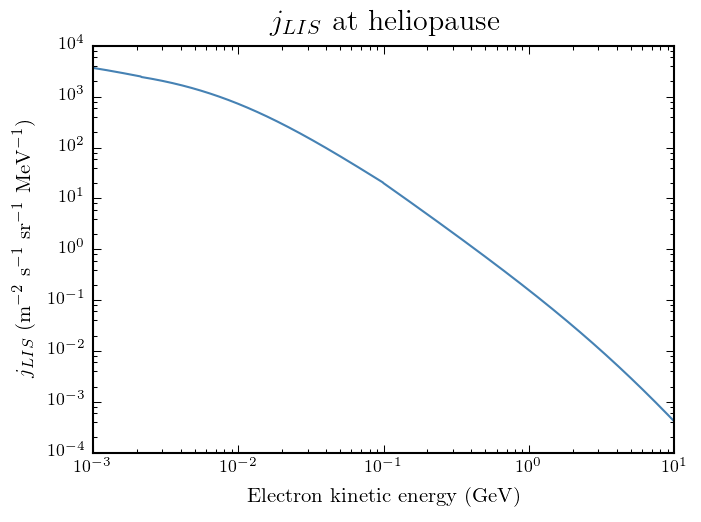

In [163]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#eksPotgieter = 10 ** np.linspace(np.log10(0.001), np.log10(50.0), 100) # Energies in GeV
#ax.plot(eks, [jLISPotgieter(ek) * (ek / 1000)**2 * 1.0e-4 for ek in eksPotgieter])

eksLangner = 10.0 ** np.linspace(-3.0, 1.0, 1000) # Energies in GeV
ax.plot(eksLangner, [jLISLangner(ek) for ek in eksLangner])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-3, 1e1)
ax.set_ylim(1e-4, 1e4)
ax.set_ylabel(r'$j_{LIS}$ (m$^{-2}$ s$^{-1}$ sr$^{-1}$ MeV$^{-1}$)')
ax.set_xlabel(r'Electron kinetic energy (GeV)')
ax.set_title(r'$j_{LIS}$ at heliopause')

plt.show()

###Compute intensity at a point

In [164]:
# Use j_LIS from Langner for comparison with Strauss et al
jLIS = jLISLangner
jLIS(1e-1)

19.861705855701953

In [165]:
def getJ(runName):
    # Load exit points
    rawData = np.loadtxt(rundataPath + runName + '.csv', delimiter = ',')
    # Parse out the coordinates and energies into a list of tuples of exit points
    exitData = [{'ee': ee, 'the': the, 'phe': phe} for ee, the, phe in zip(rawData[:,3], rawData[:,1], rawData[:,2])]
    
    # Get initial point.  --->>> TODO: store initial point in first line of csv!!!
    r0 = 1.0
    th0 = np.pi / 2.0
    ph0 = 0.0
    e0 = 0.1
    initialPoint = {'r0': r0, 'th0': th0, 'ph0': ph0, 'e0': e0}
    
    # Average LIS at exit points
    print([jLIS(ep['ee']) for ep in exitData][:10])
    j = sum([jLIS(ep['ee']) for ep in exitData]) / float(len(exitData))
    
    return (initialPoint, j)

In [166]:
# Get j(x0).  Should be 0.03...
x0, j = getJ('agt0_straussconfigs_run8')
print('e0 = ' + str(x0['e0']) + ' GeV, j(x0) = ' + str(j) + ' MeV^-1 s^-1 sr^-2 m^-2')

[1.1535904236756929, 0.17663702827259242, 1.6530520437971079, 0.24555795375250108, 0.17175764106201333, 0.34751226533856761, 0.67518377548988218, 0.30293671422908003, 0.18124060749264889, 0.55971144744019419]
e0 = 0.1 GeV, j(x0) = 0.511045009159 MeV^-1 s^-1 sr^-2 m^-2


In [167]:
x0, j = getJ('alt0_straussconfigs_run0')
print('e0 = ' + str(x0['e0']) + ' GeV, j(x0) = ' + str(j) + ' MeV^-1 s^-1 sr^-2 m^-2')

[1.2292641404369922, 0.16622903591093641, 0.72483966616957174, 0.40125608155625164, 0.48786449622908984, 1.6664473022690383, 1.3091127983239979, 1.856338717266085, 0.78865885095462251, 0.71647938979108627]
e0 = 0.1 GeV, j(x0) = 1.34869722415 MeV^-1 s^-1 sr^-2 m^-2


###Functions to compute anisotropy Earth's position

In [ ]:
def getjDerivs(fName):
    """
    fName: file name with trajectories measured to have desired energy at Earth.  The start point in this file defines
           Earth's position.  The 
    Returns: numerical approximations of dj/dr, dj/dth, dj/dph, dj/dE at Earth.
    """
    # Get j at Earth
    x, j = getJ(fName)
    # Get j at each of the points shifted spatially/spectrally from the one we care about
    x_dr, j_dr = getJ(fName + '_dr')
    x_dth, j_dth = getJ(fName + '_dth')
    x_dph, j_dph = getJ(fName + '_dph')
    x_de, j_de = getJ(fName + '_de')
    
    # Compute derivatives
    dj_dr = (j_dr - j) / (x_dr['r0'] - x['r0'])
    dj_dth = (j_dth - j) / (x_dth['th0'] - x['th0'])
    dj_dph = (j_dph - j) / (x_dph['ph0'] - x['ph0'])
    dj_de = (j_de - j) / (x_de['e0'] - x['e0'])
    
    return {"dj_dr": dj_dr, "dj_dth": dj_dth, "dj_dph": dj_dph, "dj_de": dj_de}

In [ ]:
def getAnisotropy(fName, createDerivFiles = False)
    """
    Computes anisotropy at position specified in the provided file.  Files required for computing derivatives must
    exist, unless createDerivFiles is True, in which case they will be created.  (See eq 1-2b in Jokipii and 
    Kopriva 1979.)
    """
    # Compute components of streaming flux
    f = {'r': 0.0, 'th': 0.0, 'ph': 0.0}
    
    f['r'] = k['rr']